In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [2]:
list_ds = tf.data.Dataset.list_files("../data/train/*.jpg") 

for f in list_ds.take(5):
      print(f.numpy())

b'..\\data\\train\\5_Bbeardforayear.jpg'
b'..\\data\\train\\21_igrowmybeardout.jpg'
b'..\\data\\train\\2_igrowmybeardout.jpg'
b'..\\data\\train\\32_PersonB.jpg'
b'..\\data\\train\\27_PersonC.jpg'


In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

def get_label(file_path):
  # convert the path to a list of path components
  #Get the file number as the label  
    part1 = tf.strings.split(file_path, os.path.sep)
    part2 = tf.strings.split(part1[3],"_")
      return int(part2[0]) #== Beard_Length

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  36
Image shape:  (224, 224, 3)
Label:  35
Image shape:  (224, 224, 3)
Label:  11
Image shape:  (224, 224, 3)
Label:  3
Image shape:  (224, 224, 3)
Label:  25


In [5]:
DATASET_SIZE = 352
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)
train_dataset = labeled_ds.take(train_size)
test_dataset = labeled_ds.skip(train_size)

In [6]:
train_images = []
train_labels = []
for image, label in train_dataset.take(train_size):
    train_images.append(image.numpy())
    train_labels.append(label.numpy())
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
test_images = []
test_labels = []
for image, label in test_dataset.take(test_size):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
def show_batch(image_batch, label_batch, batch_s):
    plt.figure(figsize=(10,10))
    for n in range(batch_s):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis('off')

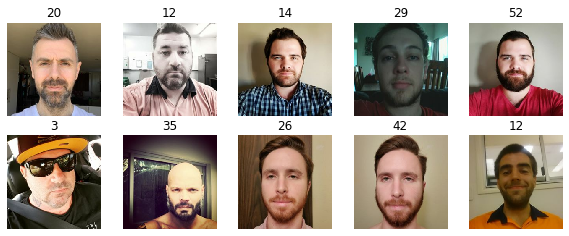

In [9]:
batch_s =10
show_batch(test_images,test_labels, batch_s)

In [10]:
batch_training = 32
image_gen_train = ImageDataGenerator(
                   rotation_range= 10,
                   width_shift_range=.15,
                   height_shift_range=.15,
                   horizontal_flip=True,
                   zoom_range=0.15,
                   channel_shift_range=0.25
                    )

In [11]:
train_data_gen = image_gen_train.flow(train_images, train_labels, shuffle = True,batch_size=batch_training)

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

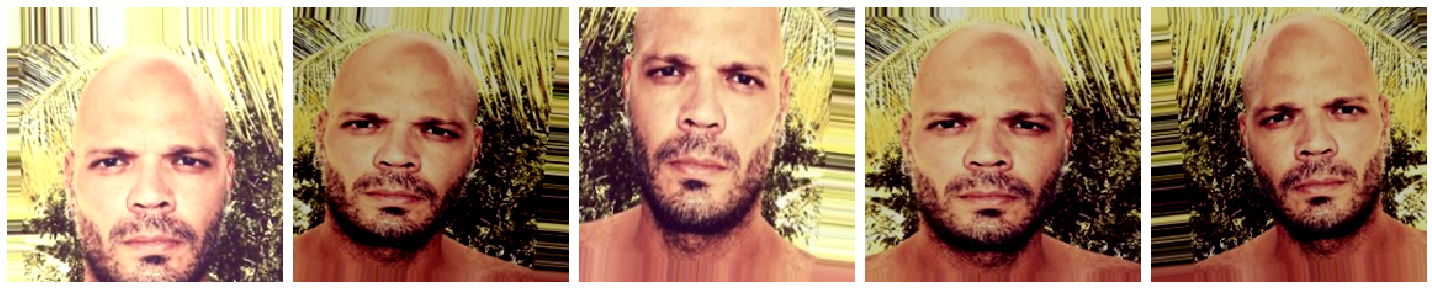

In [14]:
plotImages(augmented_images)

In [15]:
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                                         input_shape=IMAGE_SHAPE+(3,),
                                           trainable=False)

In [16]:
model = Sequential([
#  Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#  MaxPooling2D(),
#  Dropout(0.2),
#  Conv2D(32, 3, padding='same', activation='relu'),
#  MaxPooling2D(),
#  Conv2D(64, 3, padding='same', activation='relu'),
#  MaxPooling2D(),
#  Dropout(0.2),
#  Flatten(),
#  Dense(512, activation='relu'),
    
    feature_extractor_layer,
    Dense(1)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_error']
             )

In [19]:
epochs = 400
model.fit(
    train_data_gen,
    steps_per_epoch= train_size // batch_training, 
    epochs=epochs,
    validation_data=(test_images,test_labels),
    validation_steps=test_size // batch_training
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 8 steps, validate on 70 samples
Epoch 1/400
8/8 [==============================] - 9s 1s/step - loss: 727.8760 - mean_absolute_error: 22.1868 - val_loss: 661.8024 - val_mean_absolute_error: 22.4278
Epoch 2/400
8/8 [==============================] - 5s 658ms/step - loss: 575.3851 - mean_absolute_error: 19.1095 - val_loss: 526.4735 - val_mean_absolute_error: 19.4118
Epoch 3/400
8/8 [==============================] - 5s 644ms/step - loss: 452.1044 - mean_absolute_error: 16.9071 - val_loss: 421.5947 - val_mean_absolute_error: 17.0308
Epoch 4/400
8/8 [==============================] - 5s 600ms/step - loss: 342.5394 - mean_absolute_error: 14.8274 - val_loss: 347.2414 - val_mean_absolute_error: 15.5139
Epoch 5/400
8/8 [==============================] - 5s 597ms/step - loss: 300.7376 - mean_absolute_error: 14.0936 - val_loss: 296.8948 - val_mean_absolute_error: 14.5709
Epoch 6/400
8/8 [==============================] - 5s 597ms/step - loss: 275.4932 - mean_absolute_error: 13.9908 - v

8/8 [==============================] - 6s 694ms/step - loss: 182.7961 - mean_absolute_error: 11.5884 - val_loss: 176.8315 - val_mean_absolute_error: 11.5641
Epoch 50/400
8/8 [==============================] - 5s 678ms/step - loss: 172.5377 - mean_absolute_error: 11.4319 - val_loss: 175.0897 - val_mean_absolute_error: 11.5128
Epoch 51/400
8/8 [==============================] - 7s 818ms/step - loss: 178.5026 - mean_absolute_error: 11.5326 - val_loss: 175.4329 - val_mean_absolute_error: 11.4937
Epoch 52/400
8/8 [==============================] - 6s 774ms/step - loss: 175.2029 - mean_absolute_error: 11.3752 - val_loss: 176.1425 - val_mean_absolute_error: 11.4831
Epoch 53/400
8/8 [==============================] - 6s 812ms/step - loss: 183.2868 - mean_absolute_error: 11.5685 - val_loss: 174.5393 - val_mean_absolute_error: 11.4340
Epoch 54/400
8/8 [==============================] - 6s 798ms/step - loss: 171.8031 - mean_absolute_error: 11.2996 - val_loss: 171.9284 - val_mean_absolute_error: 1

8/8 [==============================] - 6s 791ms/step - loss: 130.5816 - mean_absolute_error: 9.5632 - val_loss: 133.4227 - val_mean_absolute_error: 9.7513
Epoch 98/400
8/8 [==============================] - 6s 765ms/step - loss: 125.0371 - mean_absolute_error: 9.3758 - val_loss: 131.1639 - val_mean_absolute_error: 9.6902
Epoch 99/400
8/8 [==============================] - 6s 789ms/step - loss: 130.2904 - mean_absolute_error: 9.6254 - val_loss: 131.0720 - val_mean_absolute_error: 9.6672
Epoch 100/400
8/8 [==============================] - 6s 775ms/step - loss: 122.4751 - mean_absolute_error: 9.3583 - val_loss: 128.1202 - val_mean_absolute_error: 9.5910
Epoch 101/400
8/8 [==============================] - 6s 760ms/step - loss: 135.0435 - mean_absolute_error: 9.8064 - val_loss: 127.1789 - val_mean_absolute_error: 9.5525
Epoch 102/400
8/8 [==============================] - 7s 852ms/step - loss: 128.1850 - mean_absolute_error: 9.5507 - val_loss: 126.0786 - val_mean_absolute_error: 9.5136
Ep

8/8 [==============================] - 6s 810ms/step - loss: 94.0089 - mean_absolute_error: 7.9785 - val_loss: 104.5480 - val_mean_absolute_error: 8.3534
Epoch 146/400
8/8 [==============================] - 5s 687ms/step - loss: 97.9373 - mean_absolute_error: 8.2273 - val_loss: 105.4534 - val_mean_absolute_error: 8.3402
Epoch 147/400
8/8 [==============================] - 6s 696ms/step - loss: 99.3314 - mean_absolute_error: 8.3145 - val_loss: 106.5789 - val_mean_absolute_error: 8.3371
Epoch 148/400
8/8 [==============================] - 6s 704ms/step - loss: 94.2891 - mean_absolute_error: 7.9796 - val_loss: 105.5685 - val_mean_absolute_error: 8.3073
Epoch 149/400
8/8 [==============================] - 6s 696ms/step - loss: 99.9294 - mean_absolute_error: 8.4517 - val_loss: 104.5962 - val_mean_absolute_error: 8.2830
Epoch 150/400
8/8 [==============================] - 5s 670ms/step - loss: 87.3068 - mean_absolute_error: 7.7748 - val_loss: 103.7889 - val_mean_absolute_error: 8.2599
Epoch 

8/8 [==============================] - 5s 637ms/step - loss: 76.0685 - mean_absolute_error: 6.9362 - val_loss: 89.5929 - val_mean_absolute_error: 7.6160
Epoch 195/400
8/8 [==============================] - 6s 704ms/step - loss: 80.9686 - mean_absolute_error: 7.4114 - val_loss: 89.4112 - val_mean_absolute_error: 7.6048
Epoch 196/400
8/8 [==============================] - 5s 683ms/step - loss: 85.4502 - mean_absolute_error: 7.4503 - val_loss: 90.6783 - val_mean_absolute_error: 7.6176
Epoch 197/400
8/8 [==============================] - 5s 656ms/step - loss: 83.8000 - mean_absolute_error: 7.2486 - val_loss: 90.6595 - val_mean_absolute_error: 7.6109
Epoch 198/400
8/8 [==============================] - 5s 658ms/step - loss: 79.5899 - mean_absolute_error: 7.0512 - val_loss: 87.9183 - val_mean_absolute_error: 7.5545
Epoch 199/400
8/8 [==============================] - 5s 663ms/step - loss: 80.3980 - mean_absolute_error: 7.2743 - val_loss: 88.8853 - val_mean_absolute_error: 7.5609
Epoch 200/40

8/8 [==============================] - 5s 668ms/step - loss: 73.9638 - mean_absolute_error: 7.0888 - val_loss: 77.4527 - val_mean_absolute_error: 7.1224
Epoch 244/400
8/8 [==============================] - 5s 676ms/step - loss: 78.9899 - mean_absolute_error: 7.1595 - val_loss: 83.0082 - val_mean_absolute_error: 7.2533
Epoch 245/400
8/8 [==============================] - 5s 675ms/step - loss: 71.7405 - mean_absolute_error: 6.6546 - val_loss: 82.1917 - val_mean_absolute_error: 7.2224
Epoch 246/400
8/8 [==============================] - 5s 685ms/step - loss: 75.0781 - mean_absolute_error: 6.8746 - val_loss: 76.3683 - val_mean_absolute_error: 7.0834
Epoch 247/400
8/8 [==============================] - 5s 676ms/step - loss: 64.2609 - mean_absolute_error: 6.2741 - val_loss: 74.8325 - val_mean_absolute_error: 7.0425
Epoch 248/400
8/8 [==============================] - 5s 664ms/step - loss: 77.6981 - mean_absolute_error: 7.1251 - val_loss: 74.8964 - val_mean_absolute_error: 7.0405
Epoch 249/40

8/8 [==============================] - 5s 666ms/step - loss: 65.2379 - mean_absolute_error: 6.5195 - val_loss: 71.9474 - val_mean_absolute_error: 6.7700
Epoch 293/400
8/8 [==============================] - 5s 661ms/step - loss: 64.4208 - mean_absolute_error: 6.1730 - val_loss: 69.5907 - val_mean_absolute_error: 6.6963
Epoch 294/400
8/8 [==============================] - 5s 676ms/step - loss: 65.5538 - mean_absolute_error: 6.5685 - val_loss: 70.8616 - val_mean_absolute_error: 6.7302
Epoch 295/400
8/8 [==============================] - 5s 675ms/step - loss: 67.7979 - mean_absolute_error: 6.4833 - val_loss: 69.2357 - val_mean_absolute_error: 6.6742
Epoch 296/400
8/8 [==============================] - 5s 656ms/step - loss: 64.2144 - mean_absolute_error: 6.4289 - val_loss: 68.3846 - val_mean_absolute_error: 6.6474
Epoch 297/400
8/8 [==============================] - 5s 666ms/step - loss: 64.8311 - mean_absolute_error: 6.3911 - val_loss: 68.4699 - val_mean_absolute_error: 6.6466
Epoch 298/40

8/8 [==============================] - 5s 681ms/step - loss: 68.1471 - mean_absolute_error: 6.4694 - val_loss: 67.7077 - val_mean_absolute_error: 6.4193
Epoch 342/400
8/8 [==============================] - 6s 689ms/step - loss: 56.6775 - mean_absolute_error: 6.0734 - val_loss: 64.8488 - val_mean_absolute_error: 6.3400
Epoch 343/400
8/8 [==============================] - 5s 668ms/step - loss: 63.0443 - mean_absolute_error: 6.3779 - val_loss: 63.8292 - val_mean_absolute_error: 6.3139
Epoch 344/400
8/8 [==============================] - 5s 657ms/step - loss: 54.5173 - mean_absolute_error: 5.8514 - val_loss: 65.1358 - val_mean_absolute_error: 6.3410
Epoch 345/400
8/8 [==============================] - 5s 683ms/step - loss: 61.2465 - mean_absolute_error: 6.1884 - val_loss: 68.0721 - val_mean_absolute_error: 6.4231
Epoch 346/400
8/8 [==============================] - 5s 650ms/step - loss: 61.4087 - mean_absolute_error: 6.0234 - val_loss: 64.7866 - val_mean_absolute_error: 6.3287
Epoch 347/40

8/8 [==============================] - 5s 668ms/step - loss: 56.3547 - mean_absolute_error: 6.0893 - val_loss: 61.1941 - val_mean_absolute_error: 6.0862
Epoch 391/400
8/8 [==============================] - 5s 662ms/step - loss: 55.2501 - mean_absolute_error: 6.0314 - val_loss: 61.3770 - val_mean_absolute_error: 6.0901
Epoch 392/400
8/8 [==============================] - 5s 669ms/step - loss: 52.2753 - mean_absolute_error: 5.5003 - val_loss: 64.9918 - val_mean_absolute_error: 6.2122
Epoch 393/400
8/8 [==============================] - 6s 696ms/step - loss: 56.8235 - mean_absolute_error: 5.9035 - val_loss: 65.6178 - val_mean_absolute_error: 6.2351
Epoch 394/400
8/8 [==============================] - 5s 651ms/step - loss: 58.2856 - mean_absolute_error: 6.1964 - val_loss: 64.4170 - val_mean_absolute_error: 6.1932
Epoch 395/400
8/8 [==============================] - 5s 667ms/step - loss: 52.0651 - mean_absolute_error: 5.5332 - val_loss: 64.6541 - val_mean_absolute_error: 6.1983
Epoch 396/40

In [20]:
model.evaluate(test_images,test_labels, verbose=2)

70/70 - 1s - loss: 67.3100 - mean_absolute_error: 6.1196


[67.30998785836356, 6.119557]

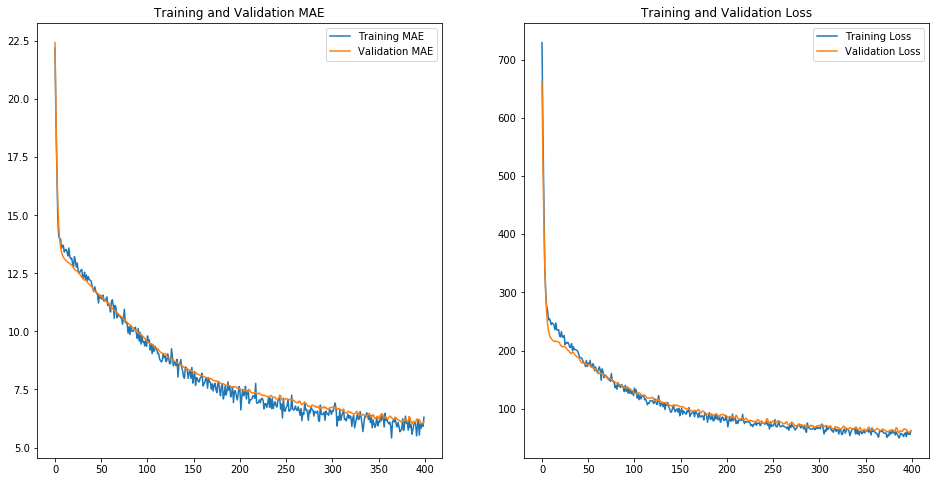

In [21]:
acc = model.history.history['mean_absolute_error']
val_acc = model.history.history['val_mean_absolute_error']

loss= model.history.history['loss']
val_loss= model.history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
predictions = pd.DataFrame(model.predict(test_images))

In [23]:
test_label = pd.DataFrame(test_labels)
pred_df = pd.concat([predictions,test_label],axis=1)
pred_df.columns = ["predictions","test_label"]

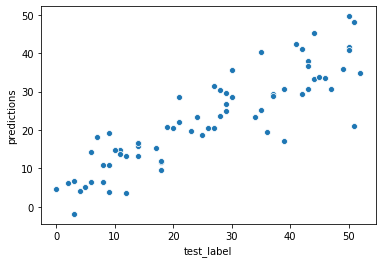

In [24]:
sns.scatterplot(x='test_label',y='predictions',data=pred_df)

# Test other images

In [25]:
"../data/train/*.jpg"
#list_test_img = tf.data.Dataset.list_files("C:\\Users\\hauer\\Downloads\\Beard_Project\\test_img_2\\*.jpg")
list_test_img = tf.data.Dataset.list_files("../data/run_images/*.jpg")
for f in list_test_img.take(4):
      print(f.numpy())

b'..\\data\\run_images\\100_WIN_20200407_23_48_45_Pro.jpg'
b'..\\data\\run_images\\100_WIN_20200407_23_48_49_Pro.jpg'
b'..\\data\\run_images\\100_WIN_20200407_23_48_39_Pro.jpg'


In [26]:
labeled_test_img = list_test_img.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_test_img.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  100
Image shape:  (224, 224, 3)
Label:  100
Image shape:  (224, 224, 3)
Label:  100


In [29]:
test_size = 3
me_test_images = []
me_test_labels = []
for image, label in labeled_test_img.take(test_size):
    #print("Image shape: ", image.numpy().shape)
    me_test_images.append(image.numpy())
    #print("Label: ", label.numpy())
    me_test_labels.append(label.numpy())
me_test_images = np.array(me_test_images)
me_test_labels = np.array(me_test_labels)

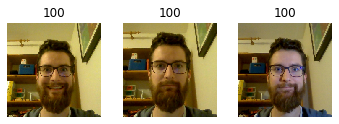

In [30]:
show_batch(me_test_images, me_test_labels, test_size)

In [31]:
predictions_me = pd.DataFrame(model.predict(me_test_images))

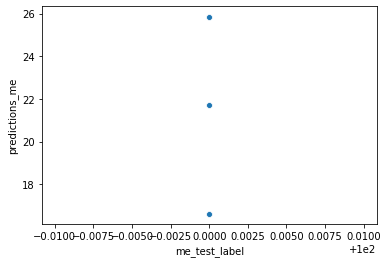

In [32]:
me_test_label = pd.DataFrame(me_test_labels)
pred_df = pd.concat([predictions_me,me_test_label],axis=1)
pred_df.columns = ["predictions_me","me_test_label"]
sns.scatterplot(x='me_test_label',y='predictions_me',data=pred_df)

In [33]:
pred_df

,predictions_me,me_test_label
0,16.624619,100
1,25.853827,100
2,21.733068,100
